In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import string
from sklearn.model_selection import train_test_split


In [2]:
csv_file_path = './airbnb_dataset/data_loo.csv'
df = pd.read_csv(csv_file_path)
pd.set_option('display.max_columns', None)
df.head()

,log_price,accommodates,bathrooms,host_response_rate,bedrooms,beds,cleaning_fee_True,host_has_profile_pic_t,property_type_encoded,room_type_encoded,bed_type_encoded,cancellation_policy_encoded,city_encoded,des_sentiment_analysis,name_sentiment_analysis
0,5.010635,-0.072621,-0.404046,0.296013,-0.312048,-0.566461,0.601901,0.055377,-0.245313,0.876836,0.168067,1.021281,-0.434017,0.216242,-0.435248
1,5.129899,1.783653,-0.404046,0.296013,2.034955,1.027816,0.601901,0.055377,-0.245338,0.876830,0.168044,1.021245,-0.434042,0.837002,-1.788095
2,4.976734,0.855516,-0.404046,0.296013,-0.312048,1.027816,0.601901,0.055377,-0.245305,0.876838,0.168074,-0.593873,-0.434009,0.808508,-0.133695
3,6.620073,0.391448,-0.404046,0.296013,0.861454,0.230678,0.601901,0.055377,0.157557,0.876747,0.167757,-1.013554,2.675098,0.213627,-0.926212
4,4.744932,-0.536689,-0.404046,0.296013,-1.485549,-0.566461,0.601901,0.055377,-0.245255,0.876851,0.168119,-0.593754,1.412368,-0.101872,-0.095776


In [3]:
features = [col for col in df.columns if col != 'log_price' and df[col].dtype in ['int64', 'float64']]
X = df[features]
y = df['log_price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [4]:
def metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    # Training metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Validation metrics
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Testing metrics
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

   # Print the metrics
    print("Training Metrics:")
    print(f"MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R2: {r2_train}")

    print("Validation Metrics:")
    print(f"MSE: {mse_val}, RMSE: {rmse_val}, MAE: {mae_val}, R2: {r2_val}")

    print("Testing Metrics:")
    print(f"MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R2: {r2_test}")

## 2nd Polynomial Regression

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.pipeline import make_pipeline
import plotly.graph_objects as go
import plotly.express as px


In [6]:
degree=2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)


Training Metrics:
MSE: 0.1901340726134661, RMSE: 0.4360436590680641, MAE: 0.3266349874382619, R2: 0.6295834950700143
Validation Metrics:
MSE: 0.1901139907889182, RMSE: 0.43602063115054335, MAE: 0.3273468576831427, R2: 0.6257665809714539
Testing Metrics:
MSE: 0.19507087666367526, RMSE: 0.4416682880439519, MAE: 0.33023937921363933, R2: 0.6286544550646068


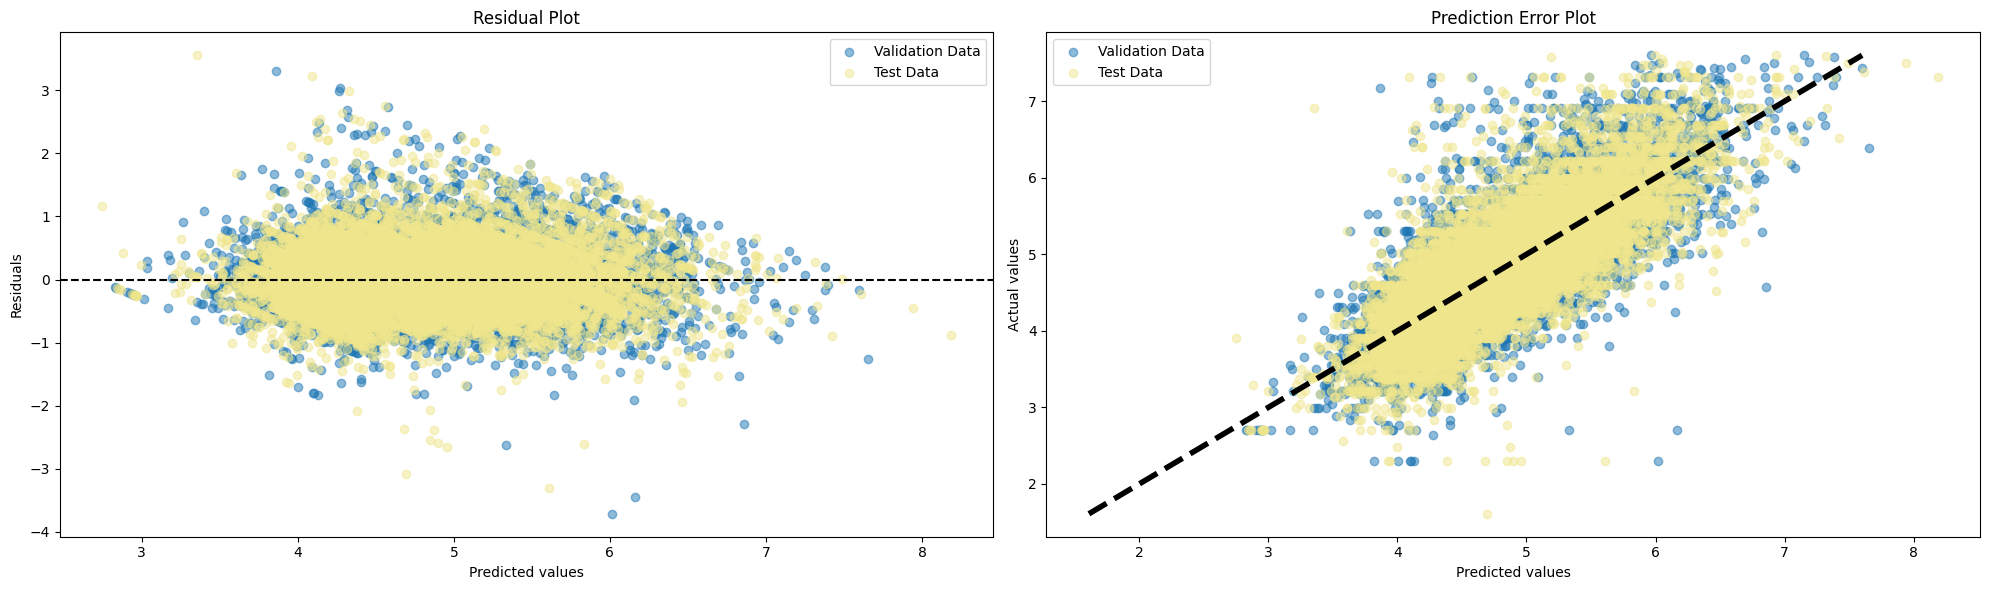

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Residual plot on the first axis
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_test_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')

# Prediction error plot on the second axis
ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_test_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted values')
ax2.set_ylabel('Actual values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Neual Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner
import keras
import tensorflow as tf

nn_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
history_nn = nn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val),verbose=0)
mse_nn = nn_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse_nn}")

463/463 [==============================] - 0s 261us/step - loss: 0.1981
Mean Squared Error on Test Set: 0.1981029510498047


### Hyperparameter Tuning

In [10]:
def build_hp_model(hp):
    model = Sequential()
    # Iterate over the number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=96, step=16),
                        activation=hp.Choice('activation_' + str(i), ['leaky_relu'])))
    
    model.add(Dense(1))  # Output layer for regression
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min',
    restore_best_weights=True,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only= False,
    mode='min'
)
tuner = keras_tuner.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_loss',
    max_trials=8,
    seed=10,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='keras_tuner_demo',
    overwrite=True
)

In [12]:
tuner_search = tuner.search(X_train, y_train, epochs=20, callbacks=[early_stopping, model_checkpoint], validation_data=(X_val, y_val))

Trial 8 Complete [00h 01m 10s]
val_loss: 0.19206532835960388

Best val_loss So Far: 0.18812439839045206
Total elapsed time: 00h 05m 37s


In [13]:
best_model = keras.models.load_model('best_model.h5')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)

metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)

463/463 [==============================] - 0s 406us/step
Training Metrics:
MSE: 0.19076574633403454, RMSE: 0.43676738240628105, MAE: 0.32659616210997156, R2: 0.6283528772821929
Validation Metrics:
MSE: 0.19334044883661655, RMSE: 0.4397049565749931, MAE: 0.3293048708909691, R2: 0.6194153996536995
Testing Metrics:
MSE: 0.1981473946505691, RMSE: 0.44513750083605524, MAE: 0.33250887105016463, R2: 0.6227978594113441


In [14]:
def plot_metrics(history, test_loss, modelName = 'Model' ,ax = None, save = False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = np.min(history.history['val_loss'])

    ax.scatter(best_epoch, best_val_loss, color='green', s=100, marker='o', label='Best Epoch')

    ax.hlines(test_loss, 0, len(history.history['loss']) - 1, colors='red', linestyles='dashed', label='Test Loss')

    ax.set_title(f'{modelName} Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    if save:
      plt.savefig(f'graphs/{modelName}.png')

In [15]:
history_best = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=0)
test_loss_best = best_model.evaluate(X_test, y_test)[0]
y_pred = best_model.predict(X_test)

463/463 [==============================] - 0s 411us/step


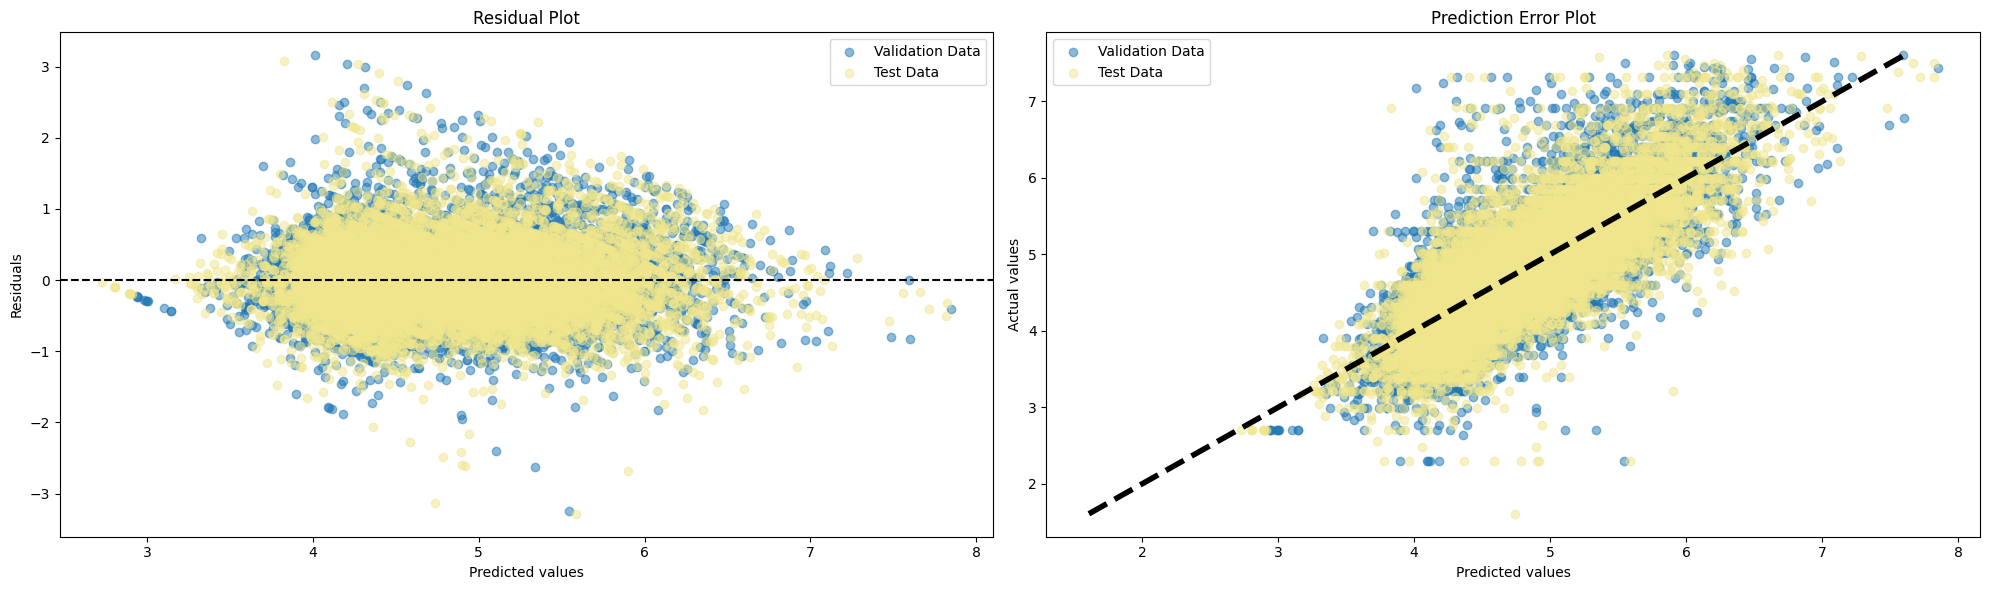

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

residuals_val = y_val - y_val_pred.flatten()  # Ensure y_val_pred is correctly shaped
residuals_test = y_test - y_pred.flatten()    # Ensure y_pred is correctly shaped


ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')


ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted values')
ax2.set_ylabel('Actual values')
ax2.legend()


plt.tight_layout()
plt.show()

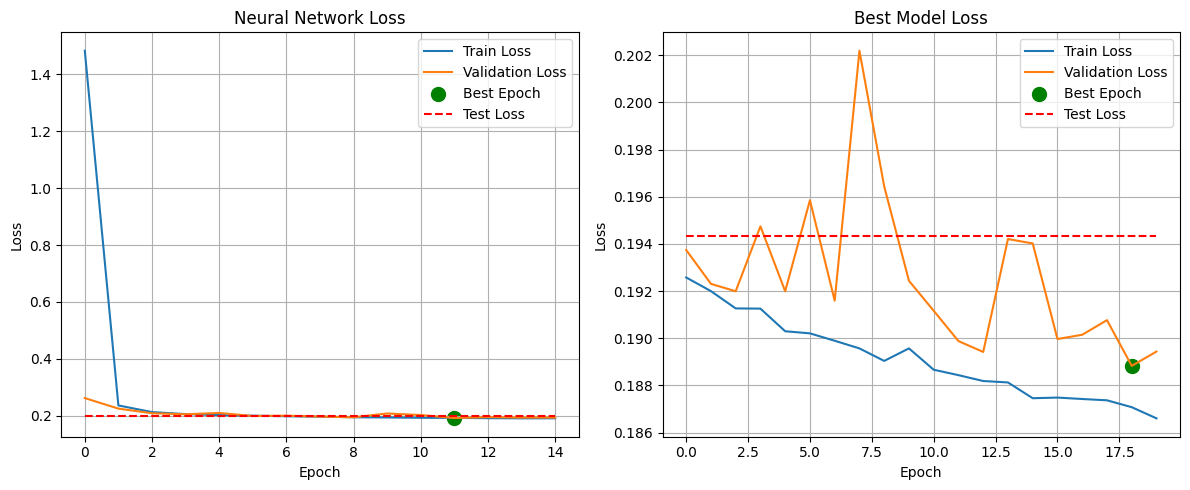

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_metrics(history_nn, mse_nn, modelName='Neural Network', ax = axs[0])
plot_metrics(history_best, test_loss_best, modelName = 'Best Model', ax = axs[1])
plt.tight_layout()
plt.show()

## XGboost

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

xgb_model = xgb.XGBRegressor(n_estimators=250, random_state=42,objective='reg:squarederror', eval_metric='rmse',early_stopping_rounds=10)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=False, n_jobs=-1)

grid_search.fit(X_train_full, y_train_full, eval_set=[(X_val, y_val)], verbose=False)

# Retrieve the best model
best_model = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.9, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.9}


In [19]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)

metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)

Training Metrics:
MSE: 3.990095652460355e-05, RMSE: 0.006316720393099852, MAE: 0.0028560806448080698, R2: 0.9999222655221337
Validation Metrics:
MSE: 3.678803375004423e-05, RMSE: 0.006065313986105272, MAE: 0.0027941136217282917, R2: 0.9999275839111447
Testing Metrics:
MSE: 0.0006183995521274416, RMSE: 0.02486764066266524, MAE: 0.005002702712506627, R2: 0.9988227872730152


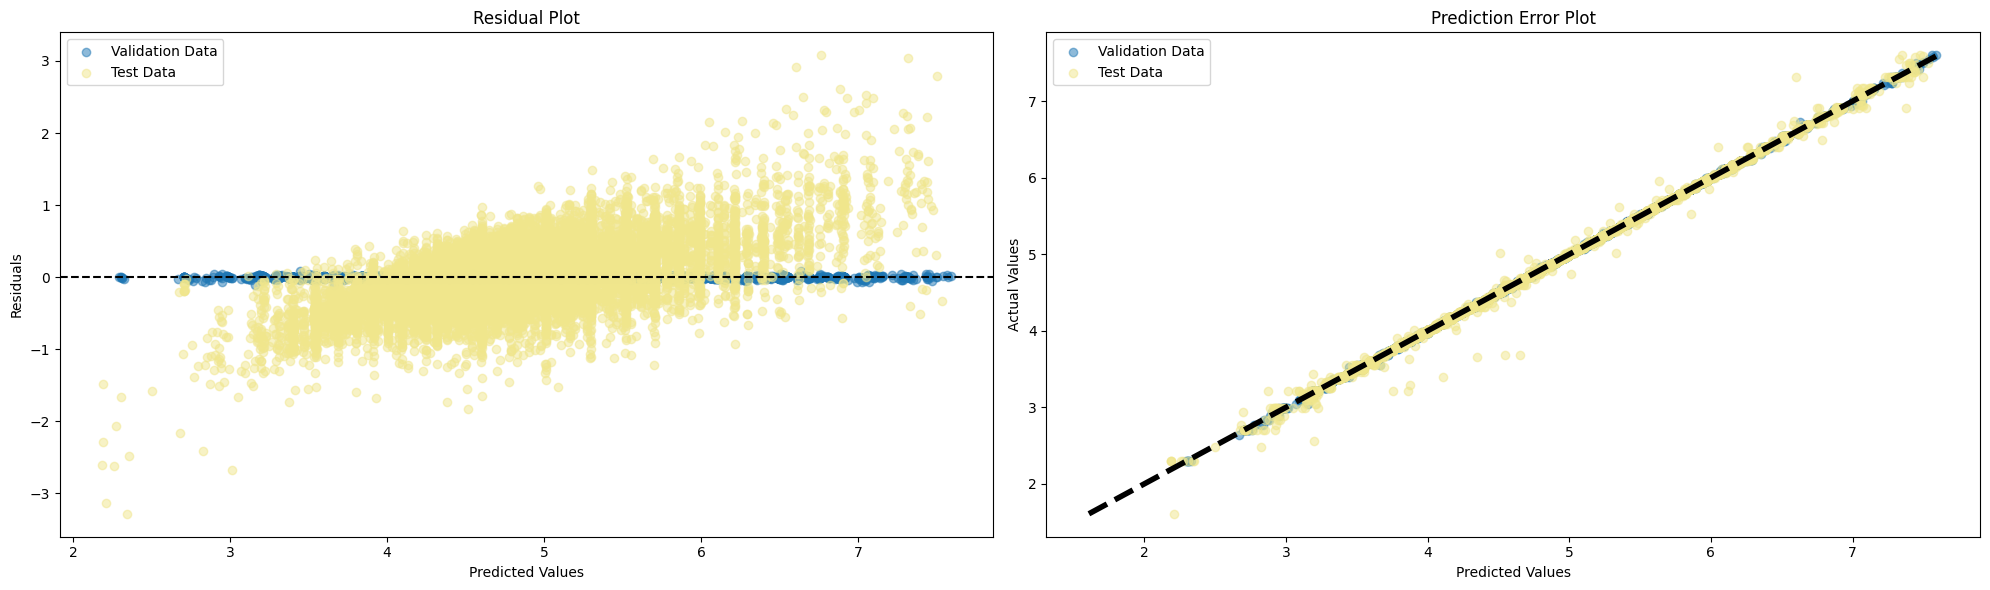

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Calculating residuals for validation and test sets
residuals_val = y_val - y_val_pred.flatten()
residuals_test = y_test - y_pred.flatten()

# Residual plot on the first axis
ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_test_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')

# Prediction error plot on the second axis
ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_test_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
# Ensure the range covers both validation and test data
all_data_range = [min(y_val.min(), y_test.min()), max(y_val.max(), y_test.max())]
ax2.plot(all_data_range, all_data_range, 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()